In [1]:
%reload_ext autoreload
%autoreload 2

In [5]:
import os
import sys

if os.getcwd().endswith("notebooks"):
    _path = os.getcwd().replace("/notebooks", "")
else:
    assert os.getcwd().endswith("receipts-xyz-python")
    _path = os.getcwd()

if _path not in sys.path:
    sys.path.append(_path)

In [235]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd

from receipts_xyz import get_weekly_attested_workouts
from receipts_xyz.api import ReceiptsXYZGraphQLAPI, ReceiptsXYZLeaderboardAPI
from receipts_xyz.schema import WeekInterval

In [8]:
# get current week range
week_interval = WeekInterval.get_current_interval()
week_interval.formatted_interval

'3 June 2024 - 9 June 2024 (UTC)'

# User statistics

## Plot user growth this week

In [285]:
all_users = pd.DataFrame(ReceiptsXYZGraphQLAPI().query_receipts_users())
all_users["time"] = all_users["time"].map(datetime.fromtimestamp)
all_users = all_users.set_index("time").sort_index()
all_users = all_users.drop_duplicates("recipient", keep="first")

In [312]:
resample = "D"

alltime_user_stats = pd.DataFrame(
    np.array([all_users.resample(resample).count()["recipient"].values,
    all_users.resample(resample).count().cumsum()["recipient"].values]).T,
    index=all_users.resample(resample).count().index,
    columns=["New user count", "cumulative user count"]
)

In [348]:
alltime_user_stats

,New user count,cumulative user count
time,,
2023-10-18,4,4
2023-10-19,49,53
2023-10-20,31,84
2023-10-21,12,96
2023-10-22,4,100
...,...,...
2024-06-05,33,5787
2024-06-06,20,5807
2024-06-07,16,5823


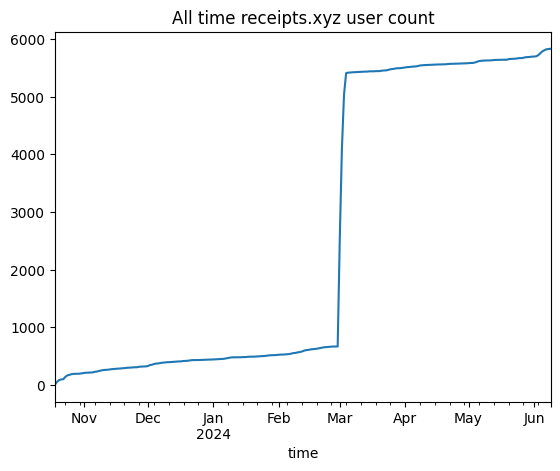

In [313]:
alltime_user_stats["cumulative user count"].plot()
plt.title("All time receipts.xyz user count")
plt.show()

In [342]:
alltime_user_stats[[x.timestamp() < week_interval.start_timestamp for x in alltime_user_stats.index]]

,New user count,cumulative user count
time,,
2023-10-18,4,4
2023-10-19,49,53
2023-10-20,31,84
2023-10-21,12,96
2023-10-22,4,100
...,...,...
2024-05-29,3,5687
2024-05-30,2,5689
2024-05-31,6,5695


In [42]:
users = ReceiptsXYZGraphQLAPI().query_receipts_users(week_interval.start_timestamp)
users_df = pd.DataFrame(users)

# ensure on duplicated new_user
assert users_df["recipient"].value_counts().max() == 1

users_df["time"] = users_df["time"].map(datetime.fromtimestamp)
users_df = users_df.set_index("time")

In [343]:
alltime_user_stats[[x.timestamp() >= week_interval.start_timestamp for x in alltime_user_stats.index]]

,New user count,cumulative user count
time,,
2024-06-03,19,5719
2024-06-04,35,5754
2024-06-05,33,5787
2024-06-06,20,5807
2024-06-07,16,5823
2024-06-08,5,5828
2024-06-09,4,5832


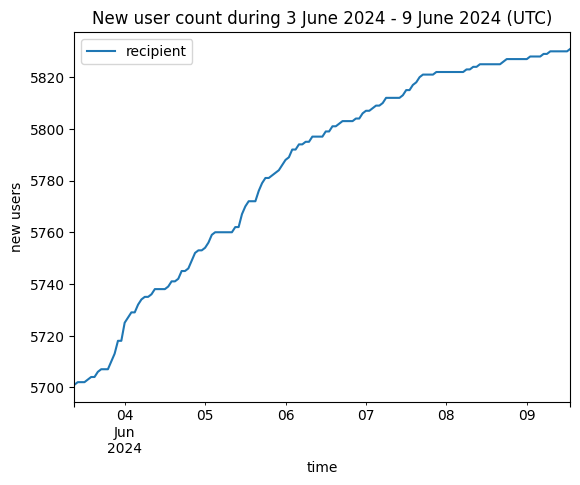

In [344]:
(users_df.resample("h").count().cumsum()["recipient"] + 5700).plot()
plt.title(f"New user count during {week_interval.formatted_interval}")
plt.ylabel("new users")
plt.legend()
plt.show()

# Weekly attested workout

In [47]:
workouts = get_weekly_attested_workouts()

workout_df = pd.DataFrame([_w.to_json() for _w in workouts])

In [48]:
workout_df.head()

,title,sport_type,receipt_type,moving_time,distance,average_speed,elevation_gain,timezone,local_time,utc_time,receipt_map,strava_single_activity,data_source,user_address
0,Afternoon Run,VirtualRun,VirtualRun,1037,2088,null,0,(GMT+07:00) Antarctica/Davis,2024-06-08T17:38:25Z,1717843105000,,True,strava,0x4632250984cc7d28b75e2af54ce7ed4a36587dd9
1,Afternoon Run,Run,Run,3399,8030,2.363,21,(GMT+07:00) Asia/Ho_Chi_Minh,2024-05-31T17:52:24Z,1717152744000,,True,strava,0x4632250984cc7d28b75e2af54ce7ed4a36587dd9
2,Afternoon Run,Run,Run,1509,3530,2.339,0,(GMT+07:00) Asia/Ho_Chi_Minh,2024-06-05T17:53:36Z,1717584816000,,True,strava,0x4632250984cc7d28b75e2af54ce7ed4a36587dd9
3,Afternoon Run,Run,Run,3467,8011,2.31,23,(GMT+07:00) Asia/Ho_Chi_Minh,2024-06-04T17:52:59Z,1717498379000,,True,strava,0x4632250984cc7d28b75e2af54ce7ed4a36587dd9
4,sat night steppin,Walk,Walk,4465,8124,null,27,(GMT-05:00) America/New_York,2024-06-08T21:06:57Z,1717895217000,,True,strava,0x7cd1fa8f4e22eb278c0dd2c46a653da2cb45bef8


## Users region

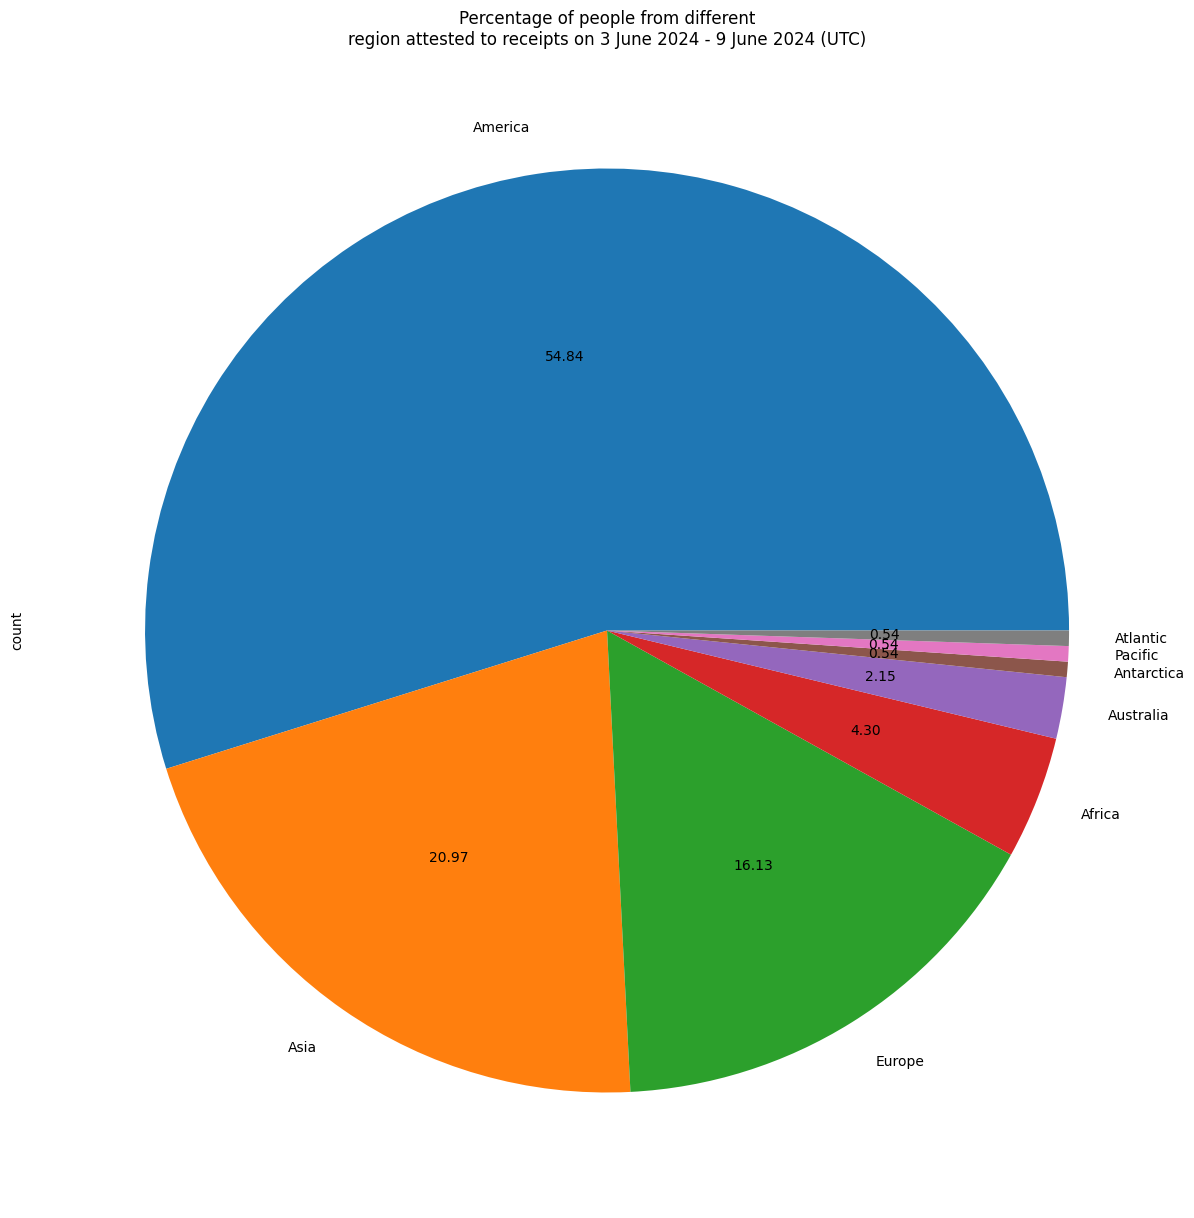

In [349]:
fig, ax = plt.subplots(figsize=(15, 15))
workout_df["timezone"].map(lambda x: x.split()[1].split("/")[0]).value_counts().plot.pie(autopct="%.2f", ax=ax)
plt.title(f"Percentage of people from different\nregion attested to receipts on {week_interval.formatted_interval}")
plt.show()

## Sport Type

In [77]:
workout_df["sport_type"].value_counts(normalize=True)

sport_type
Run               0.709677
Ride              0.080645
TrailRun          0.059140
WeightTraining    0.043011
Walk              0.032258
Workout           0.016129
GravelRide        0.010753
Yoga              0.010753
Swim              0.010753
VirtualRun        0.005376
Hike              0.005376
Elliptical        0.005376
Tennis            0.005376
Rowing            0.005376
Name: proportion, dtype: float64

## Running distance

In [353]:
workout_df[(workout_df["distance"] > 60000) & (workout_df["receipt_type"] == "Run")]

,title,sport_type,receipt_type,moving_time,distance,average_speed,elevation_gain,timezone,local_time,utc_time,receipt_map,strava_single_activity,data_source,user_address
7,Malibu Canyon 50M,TrailRun,Run,38096,78680,2.006,2747,(GMT-08:00) America/Los_Angeles,2024-06-08T05:32:01Z,1717849921000,,True,strava,0x177047bf6bce8c9dc16e4e3d6084c72d0421d3d6
24,Beltline Backyard Ultra #1,Run,Run,29991,69218,1.929,246,(GMT-05:00) America/Toronto,2024-06-07T21:00:03Z,1717808403000,,True,strava,0x09a900eb2ff6e9aca12d4d1a396ddc9be0307661


In [356]:
addr2fname["0x09a900eb2ff6e9aca12d4d1a396ddc9be0307661"]

'markcarey'

In [357]:
addr2fname["0x177047bf6bce8c9dc16e4e3d6084c72d0421d3d6"]

'andyk'

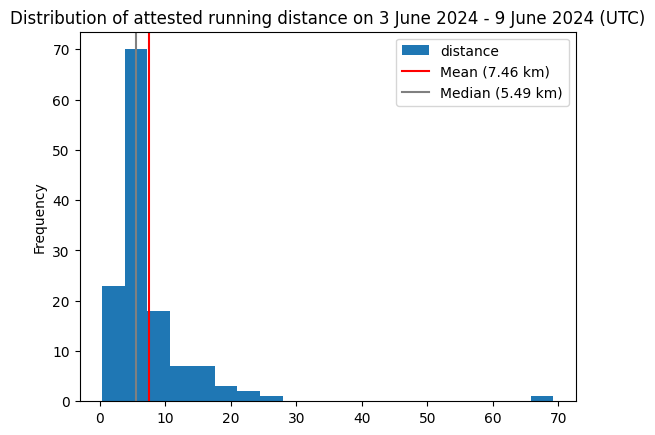

In [350]:
run_dist = workout_df[workout_df["sport_type"] == "Run"]["distance"] / 1000
run_dist.plot.hist(bins=20)
plt.axvline(run_dist.mean(), color="red", label=f"Mean ({run_dist.mean():.2f} km)")
plt.axvline(run_dist.median(), color="gray", label=f"Median ({run_dist.median():.2f} km)")
plt.title(f"Distribution of attested running distance on {week_interval.formatted_interval}")
plt.legend()
plt.show()

## Running elevation gain

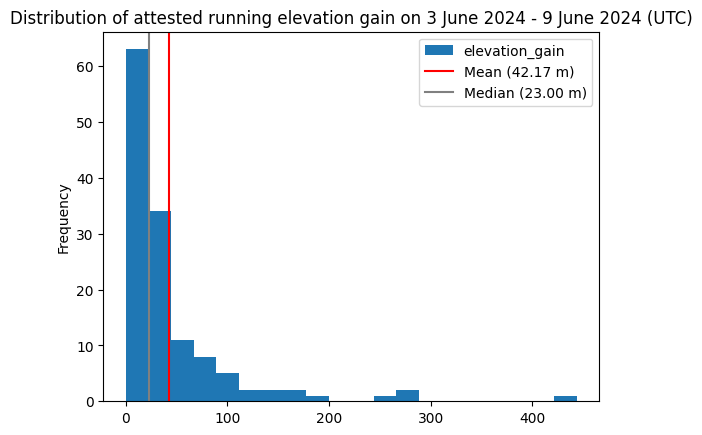

In [358]:
ele_dist = workout_df[workout_df["sport_type"] == "Run"]["elevation_gain"]
ele_dist.plot.hist(bins=20)
plt.axvline(ele_dist.mean(), color="red", label=f"Mean ({ele_dist.mean():.2f} m)")
plt.axvline(ele_dist.median(), color="gray", label=f"Median ({ele_dist.median():.2f} m)")
plt.title(f"Distribution of attested running elevation gain on {week_interval.formatted_interval}")
plt.legend()
plt.show()

## Running Time

In [160]:
running_time = workout_df[workout_df["sport_type"] == "Run"]["local_time"].map(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))

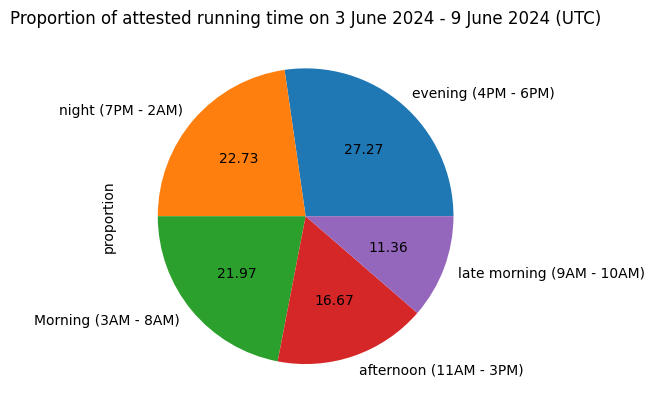

In [360]:
def group_time(hour):
    assert hour in range(24)
    if hour in [3, 4, 5, 6, 7, 8]:
        return "Morning (3AM - 8AM)"
    elif hour in [9, 10]:
        return "late morning (9AM - 10AM)"
    elif hour in [11, 12, 13, 14, 15]:
        return "afternoon (11AM - 3PM)"
    elif hour in [16, 17, 18]:
        return "evening (4PM - 6PM)"
    else:
        return "night (7PM - 2AM)"

running_time.dt.hour.map(group_time).value_counts(normalize=True).plot.pie(autopct="%.2f")
plt.title(f"Proportion of attested running time on {week_interval.formatted_interval}")
plt.show()

## Running duration

In [214]:
def format_second(seconds: int) -> str:
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    if hours > 0:
        return f"{hours:02} hours {minutes:02} minutes {remaining_seconds:.2f} seconds"
    else:
        return f"{minutes:02} minutes {remaining_seconds:00.2f} seconds"

In [206]:
workout_df[workout_df["receipt_type"] == "Run"]["moving_time"].describe()

count      143.000000
mean      3241.279720
std       4143.066933
min         62.000000
25%       1670.500000
50%       2200.000000
75%       3328.000000
max      38096.000000
Name: moving_time, dtype: float64

In [215]:
format_second(workout_df[workout_df["receipt_type"] == "Run"]["moving_time"].mean())

'54 minutes 1.28 seconds'

## Higher Challenge

`https://paragraph.xyz/@higher-athletics/running-challenge-june`
> 3 weeks, June 3 - 23
> 
> 20 km per week, 60 km in total, attested w /receipts
> 
> 35k $HIGHER split between everyone who finishes

In [236]:
leaderboard = ReceiptsXYZLeaderboardAPI().get_weekly_leaderboard()
leaderboard = pd.DataFrame(leaderboard)

In [247]:
account_mapper = leaderboard[["wallet_address", "fname", "ens"]].copy()

## Top 10 Attested Single workout

In [250]:
addr2fname = {_r.wallet_address: _r.fname for _, _r in account_mapper.iterrows()}
addr2ens = {_r.ens: _r.fname for _, _r in account_mapper.iterrows()}

In [255]:
# top 10 attested distance in km
top10_run_dist = workout_df[workout_df["receipt_type"] == "Run"]\
    .groupby("user_address")["distance"].sum()\
    .sort_values(ascending=False)[:10].copy() / 1000
top10_run_dist.index = list(map(lambda x: addr2fname.get(x, x) or addr2ens.get(x, x), top10_run_dist.index))
top10_run_dist

andyk                                         78.680
chompk                                        74.152
markcarey                                     69.218
halfbreed                                     68.499
0x126d2cebd1ff6da07ccbc905fd6e0ee97ca265ad    38.122
0x7552d4f6daacb2e09aca3cfbaab58bc3ad3e66fa    36.037
0xcacc3d8b0975f1aff85221e989a59ec60f28efc5    35.203
0xced09ccfc82b091195bde04e6cd65374518e7b95    33.838
0x7538934c886810cc77fce8c6951961b018f01d49    32.843
annelisa                                      28.483
Name: distance, dtype: float64

In [273]:
# top 10 attested distance in km
top10_ele = workout_df[workout_df["receipt_type"] == "Run"]\
    .groupby("user_address")["elevation_gain"].sum()\
    .sort_values(ascending=False)[:10]
top10_ele.index = list(map(lambda x: addr2fname.get(x, x) or addr2ens.get(x, x), top10_ele.index))
top10_ele
top10_ele

andyk                                         2747
0xced09ccfc82b091195bde04e6cd65374518e7b95    1218
acidflower                                     716
chompk                                         609
nathanabauman                                  519
0xf6591c74c46762d94765a6ad27368ceaf5cea475     446
patxol.eth                                     401
0xcacc3d8b0975f1aff85221e989a59ec60f28efc5     319
ernestkou                                      308
phragg                                         267
Name: elevation_gain, dtype: int64